c:\Users\ABC\OneDrive\Skrivbord\RHP HERE\rhp\simulations\debugging\../../../rhp\rhp_plan.py:91: OptimizeWarning: Unknown solver options: tol
  result = optimize.linprog(c=aggregate_primary_resource_vector,
c:\Users\ABC\OneDrive\Skrivbord\RHP HERE\rhp\simulations\debugging\../../../rhp\rhp_plan.py:97: OptimizeWarning: Unknown solver options: tol
  lagrange_ineq = -optimize.linprog(c=aggregate_primary_resource_vector,


True
0
True
0
True
0
[1. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[ 1.  1.  0. ...  0.  0.  0.]
 [ 1.  0.  1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 1.  0.  0. ...  0.  1. -1.]
 [ 1.  0.  0. ...  0.  1. -1.]
 [ 1.  0.  0. ...  0.  0.  1.]]
[[ 1.]
 [20.]
 [20.]
 [20.]
 [10.]
 [ 1.]
 [20.]
 [20.]
 [20.]
 [10.]
 [ 1.]
 [20.]
 [20.]
 [20.]
 [10.]
 [ 1.]
 [20.]
 [20.]
 [20.]
 [10.]
 [ 1.]
 [20.]
 [20.]
 [20.]
 [10.]
 [ 1.]
 [20.]
 [20.]
 [20.]
 [10.]
 [ 1.]
 [20.]
 [20.]
 [20.]
 [10.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [5.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [7.]
 [7.]
 [7.]
 [7.]
 [7.]]


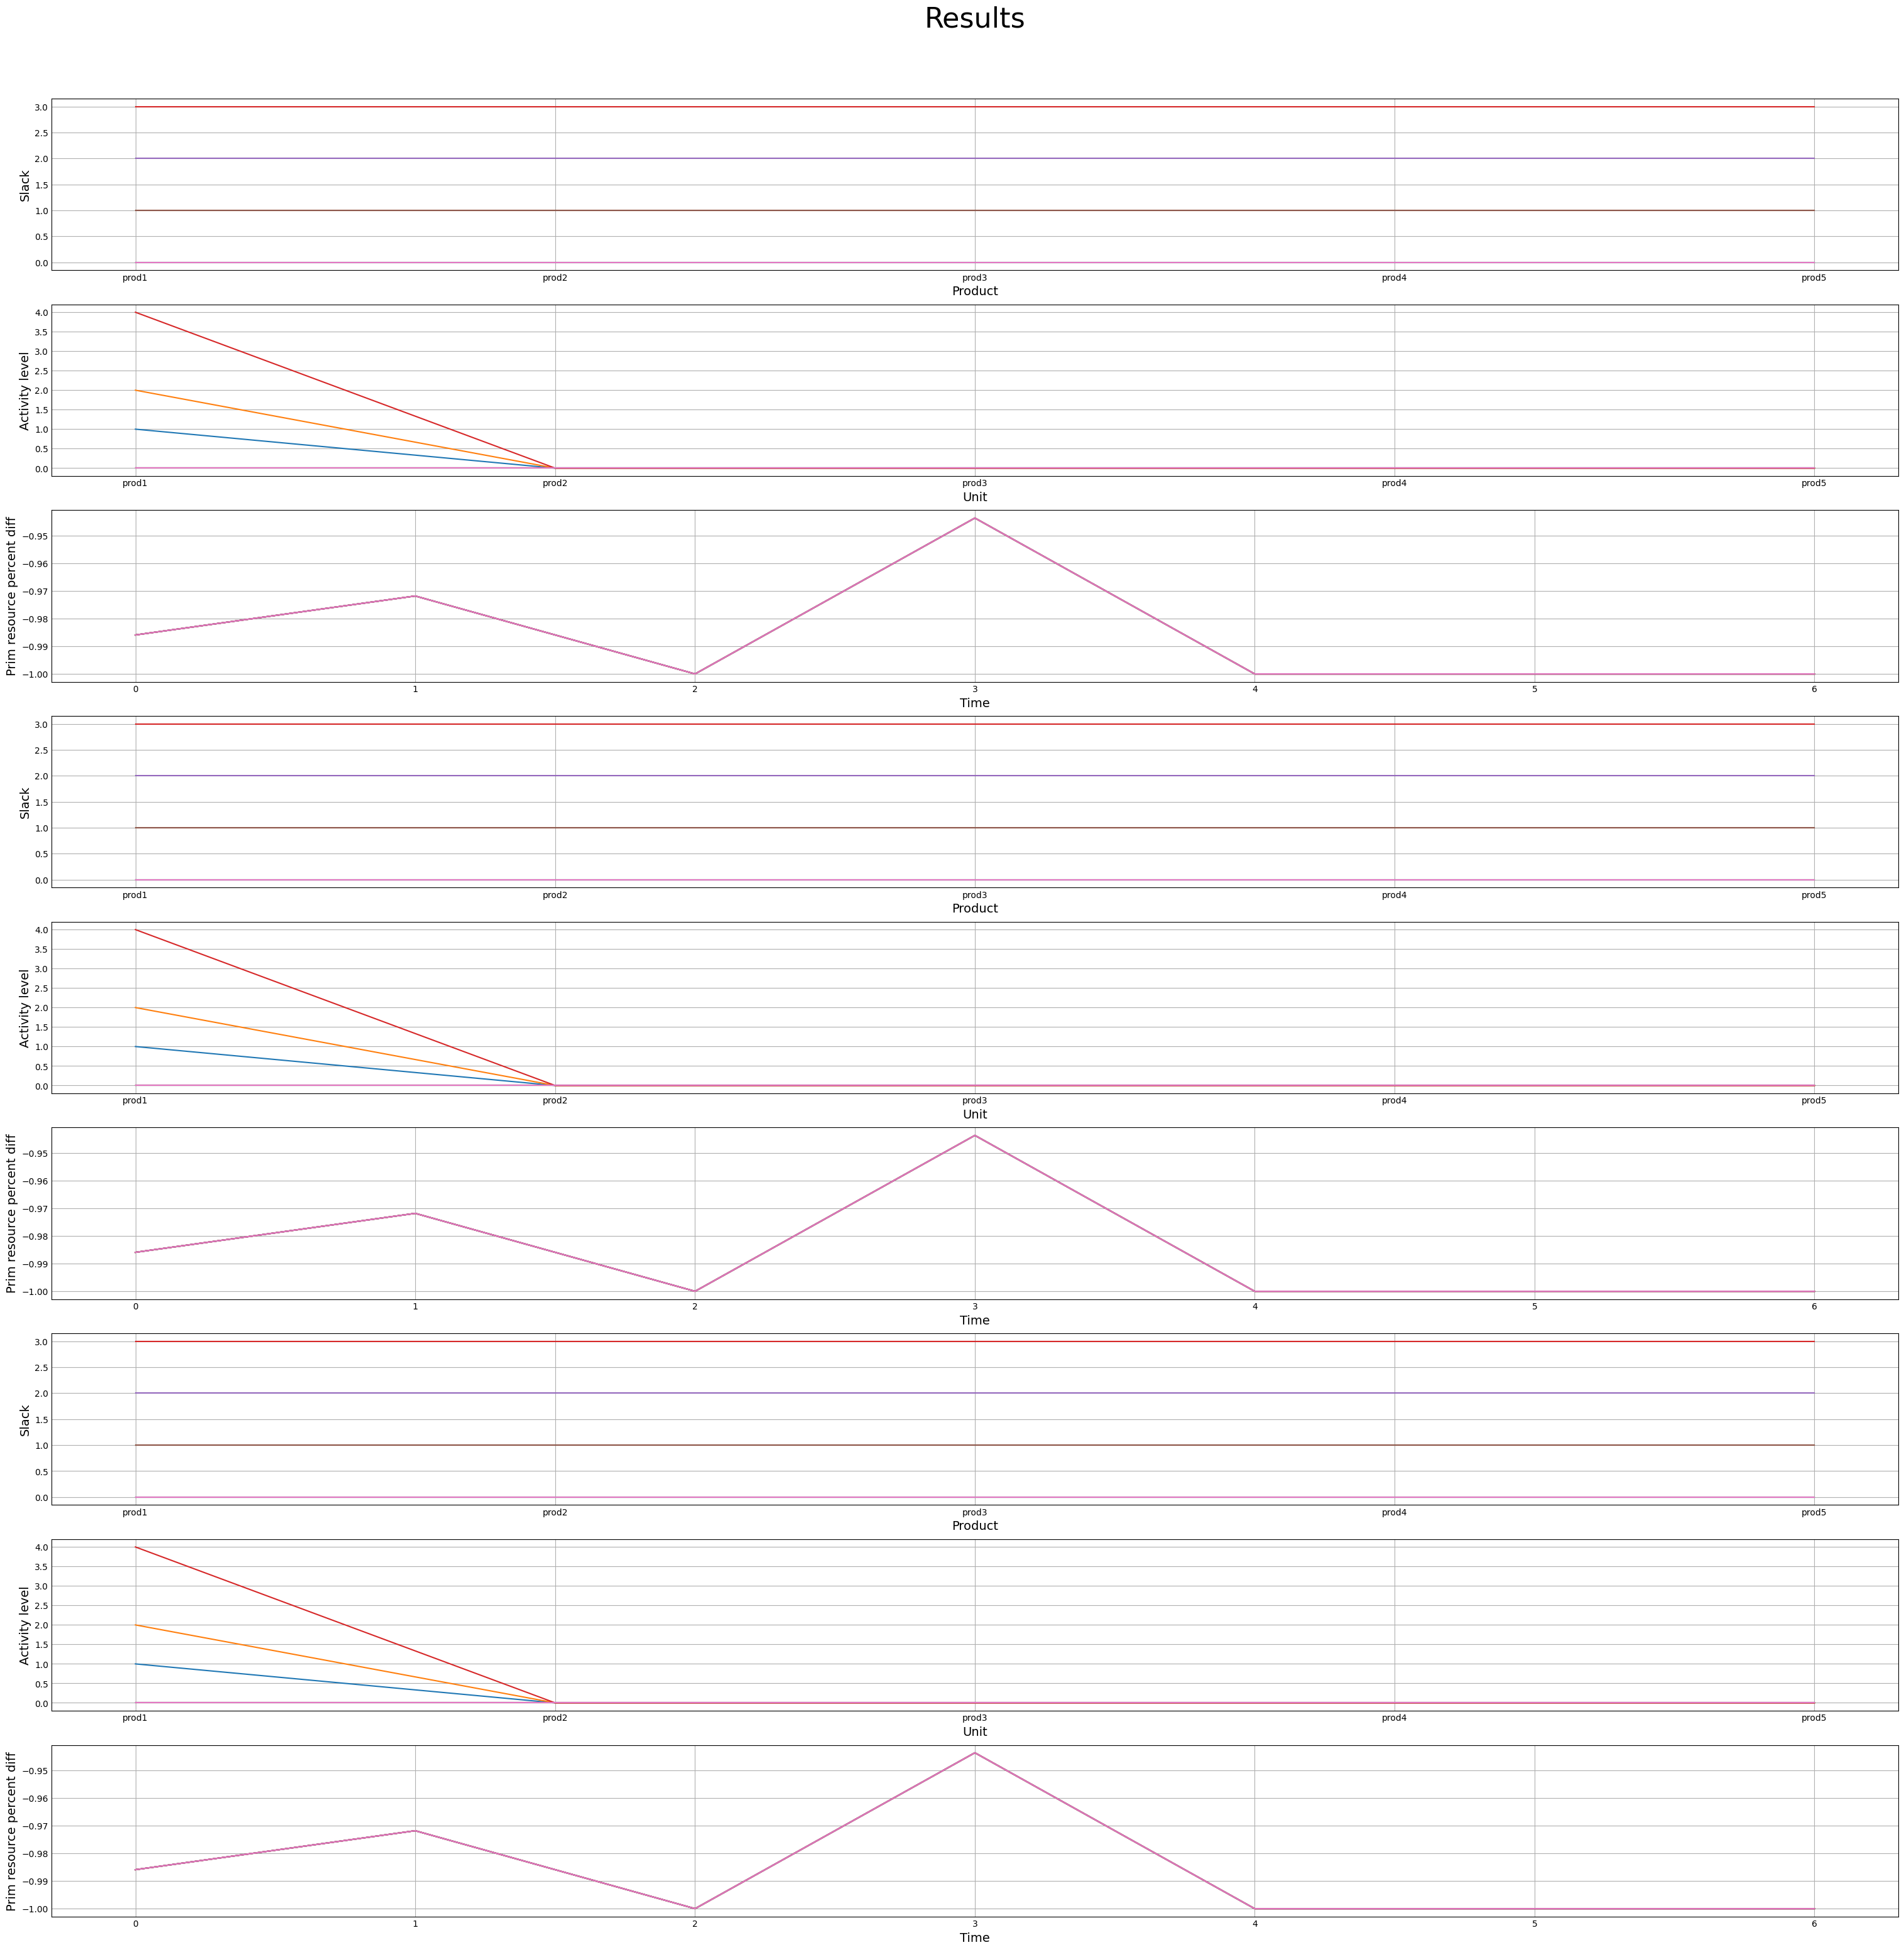

In [1]:
import sys 
sys.path.append("../../../rhp")
from rhp_plan import plan
from pathlib import Path
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import deepcopy

#Excel information extraction
xlsx_file = Path('debugging.xlsx')
main_sheet = openpyxl.load_workbook(xlsx_file)['2016']

#Division with zero-exception
def zdivide(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

#List constructor
def matrix_list_maker(to_matrix, list_length):
    return ([np.matrix(to_matrix)]*list_length)    

# Generates a 2D list of values from an xlsx file, reading left to right, top to bottom.
class Sheet:
    def __init__(self, sheet, left: int, top: int, right: int, bottom: int):
        result_sheet = []
        coordinates = []
        for row in sheet.iter_rows(min_row=left, min_col=top, max_row=right, max_col=bottom):
            data = []
            pos = []
            for cell in row:
                data.append(cell.value)
                pos.append(cell)

            result_sheet.append(data)
            coordinates.append(pos)

        self.result = result_sheet
        self.coordinates = coordinates

    @property
    def np_array(self):
        return np.array(self.result, dtype=np.float64)

#Input values and list construction
time_steps = 3
planning_horizon = 6
step_horizon = time_steps + planning_horizon + 1


export_constraint_boolean = False

#Notation
notation = ['prod1', 'prod2', 'prod3', 'prod4', 'prod5']
if export_constraint_boolean:
    notation.append('EXP')


supply_use = Sheet(main_sheet, 2, 2, 6, 6).np_array
depreciation = np.array(np.eye(N=supply_use.shape[0], M=supply_use.shape[0], k=0))
use_imported_list, imported_export_target_output_list, imported_export_target_output_list, imported_target_output_list, import_prices_list, imported_export_target_output_list, export_prices_list = [], [], [], [], [], [], []
supply_use_list = matrix_list_maker(supply_use,step_horizon)
depreciation_list = matrix_list_maker(depreciation,step_horizon)
full_domestic_target_output = Sheet(main_sheet, 2, 8, 6, 8).np_array
full_domestic_target_output_list = matrix_list_maker(full_domestic_target_output,step_horizon)
primary_resource = Sheet(main_sheet, 8, 2, 8, 6).np_array.reshape([-1,1])
primary_resource_list = matrix_list_maker(primary_resource,step_horizon)

#Plan
plan_outcome = plan(time_steps=time_steps, planning_horizon=planning_horizon, primary_resource_list=primary_resource_list, 
                    supply_use_list=supply_use_list, use_imported_list=use_imported_list, depreciation_list=depreciation_list, 
                    full_domestic_target_output_list=full_domestic_target_output_list, 
                    imported_target_output_list=imported_target_output_list, 
                    export_constraint_boolean=export_constraint_boolean, 
                    export_prices_list=export_prices_list, import_prices_list=import_prices_list,
                    upper_bound_on_activity = None, max_iterations=1000, tolerance=10e-8)

# plan details
result_list = plan_outcome[0]
lagrange_list = plan_outcome[1]
slack_list = plan_outcome[2]
final_list_resource = plan_outcome[3]
final_list_matrix = plan_outcome[4]
final_list_target = plan_outcome[5]

print(result_list[0])
print(final_list_matrix[0])
print(final_list_resource[0])
print(final_list_target[0])


plt.style.use('_mpl-gallery')
fig = plt.figure(figsize=(30, 180))
fig.suptitle('Results', fontsize=32)
number_of_graphs = 3
gs = gridspec.GridSpec(number_of_graphs * time_steps * planning_horizon, 1)

labels = ['Slack',
            'Activity level',
            'Lagrange multiplier',
            'Worked hours (10K)',
            'CO2',
            'Prim resource percent diff']

for i in range(time_steps):
    
    ax = fig.add_subplot(gs[i * number_of_graphs + 1, 0])
    ax.set_xlabel('Product', fontsize=14)
    ax.set_ylabel(labels[0], fontsize=14)
    ax.set_xticks(range(supply_use_list[i].shape[0]), notation)
    for j in range(planning_horizon+1):
        s = np.array_split(slack_list[i], planning_horizon+1)
        ax.plot(range(s[j].shape[0]), s[j])

    ax = fig.add_subplot(gs[i * number_of_graphs + 2, 0])
    ax.set_xlabel('Unit', fontsize=14)
    ax.set_ylabel(labels[1], fontsize=14)
    ax.set_xticks(range(supply_use_list[i].shape[1]), notation)
    for j in range(planning_horizon+1):
        x = np.array_split(result_list[i], planning_horizon+1)
        ax.plot(range(x[j].shape[0]), x[j])

    resulting_worked_hours = [] 
    x = np.array_split(result_list[i], planning_horizon+1)
    for j in range(planning_horizon+1):
        resulting_worked_hours.append((np.matmul(primary_resource.reshape([1,-1]), x[j]).item(0)-np.sum(primary_resource))/(np.sum(primary_resource)))
    ax = fig.add_subplot(gs[i * number_of_graphs + 3, 0])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(labels[5], fontsize=14)
    for j in range(planning_horizon+1):
        ax.plot(range(planning_horizon+1), resulting_worked_hours)


plt.show()
